https://stackoverflow.com/questions/53838696/problems-regarding-pyomo-provided-math-functions

https://stackoverflow.com/questions/70048818/optimization-of-a-battery-storage-with-pyomo

https://gitlab.com/diw-evu/emobpy/emobpy/-/blob/master/emobpy/data/evspecs.json

https://github.com/L-Strobel/jointAnalysisCharging/tree/main/chargingmodel

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
import matplotlib.axes as axes
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output
from pyomo.opt import SolverFactory
import random
from pandas import Timestamp
import pickle
import matplotlib.dates as mdates


## Data input 

In [46]:
V2G = True

In [47]:
#emobpy import
processing_path = os.getcwd()
os.chdir("../emobpy/save")
data_path = os.getcwd()
os.chdir(processing_path)

consumption_ts = pd.read_pickle(os.path.join(data_path,  "consumption"))
availability_ts = pd.read_pickle(os.path.join(data_path, "availability"))
car_properties_raw = pd.read_pickle(os.path.join(data_path,  "properties")) 

profiles = 100#min(consumption_ts.shape[1], availability_ts.shape[1], car_properties_raw.shape[1])
time_steps = 500#len(availability_ts.index)

In [48]:
#consumption = pd.DataFrame(data = np.array([[0, 0.5], [0, 0.5], [0.5, 0], [0.5, 0]]), columns = ["c_1[kW]", "c_2[kW]"])
#power = pd.DataFrame(pd.DataFrame(data = np.array([[1, 0], [1, 0], [0, 1], [0, 1]]), columns = ["p_1 [kW]", "p_2 [kW]"]))

#kWh / 15 min timestep
consumption_raw, power_raw, car_properties_raw = consumption_ts.iloc[:time_steps, :profiles], availability_ts.iloc[:time_steps, :profiles], car_properties_raw.iloc[:, :profiles]
neg_power_magnitude_raw = power_raw

#set datetime indexes 
index = consumption_ts.index[:time_steps]
consumption_raw.index, power_raw.index, neg_power_magnitude_raw.index = index, index, index

In [49]:
step_duration = int(pd.infer_freq(index)[:-1]) / 60  #parts of an hour

soc_min = 0.1 #level that should preferably be reached as soon as possible

## Data plausibility

<BarContainer object of 2 artists>

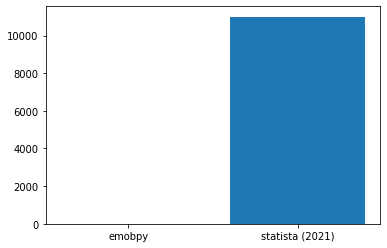

In [50]:
#average consuption of 200Wh per 100 km --> 
#median in Geramny is at about 11000 km per year
plt.bar(
    ["emobpy", "statista (2021)"], [(consumption_raw*step_duration).sum().mean() / 0.2, 11000]
       )

Text(0, 0.5, 'power rating [kW]')

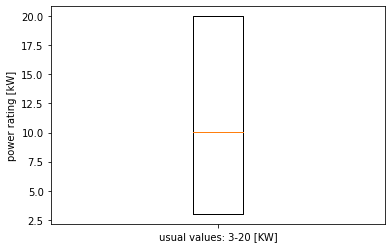

In [51]:
#power ratings are mostly between 3 and 20 kW 
ax = plt.boxplot(
    [3,3, power_raw.mean(1).mean(), 20,20], labels=["usual values: 3-20 [KW]"]
       )

plt.ylabel('power rating [kW]')

In [52]:
def plot_step(df, consumption=True):
    df_ = df.copy()
    
    if type(df.index[0]) == int:
        df_.loc[df_.index[-1]+1,:] = df_.iloc[-1,:]
    else:
        df_.loc[str(pd.Timestamp(df_.index[-1] ) + 
                    pd.Timedelta(pd.infer_freq(index))),:
               ] = df_.iloc[-1,:]
        
    df_.index = pd.to_datetime(df_.index)
    
    fig, ax = plt.subplots(2)
    time_constrained=df_[df_.index.date <= df_.index[0].date()]
    x = time_constrained.index
    ax[0].step(x=x, y = time_constrained.iloc[:,2], where = "post")
    ax[1].step(x=x, y = time_constrained.sum(1).to_frame().rename(columns={0:"aggregated"}), where = "post")
    for i in [0,1]:
        ax[i].xaxis.set_major_locator(mdates.HourLocator())
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        if consumption == True: ax[i].set_ylabel("kWh/15min")
        else: ax[i].set_ylabel("kW")
        if i == 0: ax[i].set_title("one single profile")
        else: ax[i].set_title("aggregated profile")
        ax[i].set_xlabel("hour of the day")
        
        ax[i].set_ylim(bottom=0)
        
    fig.tight_layout()
    plt.show()


Text(0, 0.5, 'consumption [kWh / 15min]')

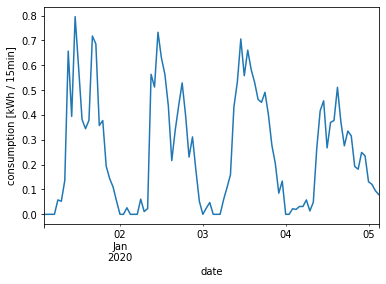

In [53]:
fix, ax = plt.subplots()

consumption_raw.iloc[10:400].sum(1).resample("1h").mean().plot()
plt.ylabel("consumption [kWh / 15min]")

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=7))
#ax.xaxis.set_major_formatter(mdates.DateFormatter("%a"))

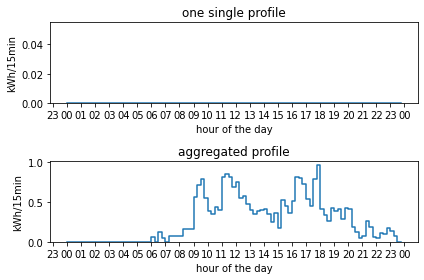

In [54]:
plot_step(consumption_raw)

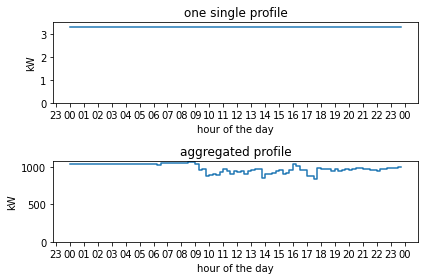

In [55]:
plot_step(power_raw, consumption = False)

In [56]:
#plausibility: Are power availability and battery size in reasonable 
#realtion to each other?
(consumption_raw*step_duration).sum(1).max() / car_properties_raw.iloc[2].sum()

3.925182882632152e-05

# EES-transformation: Generating uncontrolled and latest charging ts

In [57]:
##level= [0, 2]
##level_ = [0, 1]

#set same names for columns
power_raw.columns = consumption_raw.columns
neg_power_magnitude_raw.columns = consumption_raw.columns
car_properties_raw.columns = consumption_raw.columns

In [58]:
solution_dict = {}
ees_constraints= pd.DataFrame()

for car in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[car].columns
    except AttributeError as a:
        car_list = [car]
        
    for i, c in enumerate(car_list):
        print(i) 
        print(c)

        if type(consumption_raw[c]) == pd.core.series.Series:
            consumption= consumption_raw[c]
            power= power_raw[car]
            neg_power_magnitude= neg_power_magnitude_raw[c]
            car_properties= car_properties_raw[c]

        else: 
            consumption= consumption_raw[c].iloc[:,i]
            power= power_raw[car].iloc[:,i]
            neg_power_magnitude= neg_power_magnitude_raw[c].iloc[:,i]
            car_properties= car_properties_raw[c].iloc[:,i]
            

        solution_dict[car+str(i)] = {}
        level_0 = car_properties["soc_init"]
        level_T = car_properties.loc["soc_end"]
        battery_capacity = car_properties.loc["battery_capacity"]

        for model_type in ["m_late", "m_early"]:

            #Initialize model
            m = pyo.ConcreteModel()
            #initialize sets
            m.t = pyo.Set(initialize = index, ordered = True)

            #Initialize parameter
            m.consumption = pyo.Param(m.t, initialize=consumption.to_dict())
            m.power = pyo.Param(m.t, initialize=power.to_dict()) 
            m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.to_dict()) 

            #Initialize variables
            m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.SLACK = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                              bounds = (0,battery_capacity))

            #level constraints
            def recursive_level(m, t):
                if t == index[0]:
                    return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration
                else:    
                    return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                     pd.Timedelta(pd.infer_freq(index))] + (
                        m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration   
            m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

            def final_level(m, t):
                if t == index[-1]:
                    return m.LEVEL[t] == level_T
                else: 
                    return pyo.Constraint.Skip
            m.Final_level = pyo.Constraint(m.t, rule=final_level)

            #bidirectional charging 
            def neg_power_min(m, t):
                if V2G == True:
                    return m.DISCHARGE[t] <= m.neg_power[t] 
                else:
                    return m.DISCHARGE[t] ==0
            m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)

            def power_max(m, t):
                return m.CHARGE[t] <= m.power[t]   
            m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)
            
            def avoid_min_level(m, t):
                return m.LEVEL[t] + m.SLACK[t] >= soc_min*battery_capacity 
            m.avoid_min_level = pyo.Constraint(m.t, rule=avoid_min_level)
            
        
            def battery_level_sum(m, t): 
                return sum(m.LEVEL[t] for t in m.t) 
            
            if model_type == "m_late":
                M = 10000
                def battery_level_sum(m, t): 
                    return sum(m.LEVEL[t] + M * m.SLACK[t] for t in m.t)  
                sense = pyo.minimize
                
            elif model_type == "m_early":
                def battery_level_sum(m, t): 
                    return sum(m.LEVEL[t] for t in m.t) 
                sense = pyo.maximize     
            m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

            #find solver
            solvername='glpk'

            #prepare solver
            optimizer = opt.SolverFactory(solvername) 
            solved_model = optimizer.solve(m, tee=True)        

            if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
                level_series = pd.concat([
                    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                    pd.Series(level_0, index=index)
                ], axis=0)
                charge_df = pd.DataFrame(0, index=index, columns = [car])
                discharge_df = pd.DataFrame(0, index=index, columns = [car])
            else: 
                level_series = pd.concat([
                    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                    pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
                ], axis=0)
                charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
                discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])
            
            #store data in dictionary
            solution_dict[car+str(i)][model_type] = {}
            solution_dict[car+str(i)][model_type]["level"] = level_series
            solution_dict[car+str(i)][model_type]["charge"] = charge_df
            solution_dict[car+str(i)][model_type]["discharge"] = discharge_df
            level_index = solution_dict[car+str(i)][model_type]["level"].index
            if model_type == "m_early":
                solution_dict[car+str(i)]["level_differences"] = (solution_dict[car+str(i)]["m_late"]["level"] - 
                                                           solution_dict[car+str(i)]["m_early"]["level"]).to_frame().rename(columns={0:car})
                ees_constraints= pd.concat([ees_constraints, solution_dict[car+str(i)]["level_differences"]], axis = 1)

0
FIAT/500e/2019
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpsx1cam0w.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpgrxwt7vy.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpbeo8mydh.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpbeo8mydh.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpgrxwt7vy.glpk.glp'...
11033 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1460 columns, 2458 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   3.500101689e+04 inf =   2.247e+03 (523)
    738: obj =   1.713953814e+05 inf =   0.000e+00 (0) 4
Perturbing 

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpw72iurm9.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp_17a5y9v.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpoytawhts.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpoytawhts.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp_17a5y9v.glpk.glp'...
10525 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1430 columns, 2428 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   4.671052632e-01 inf =   1.630e+03 (529)
    483: obj =   1.622835789e+03 inf =   1.332e-15 (0)
*   945: obj =   1.465976461e+

7
FIAT/500e/2019
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpzs2v87fg.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpfv7ogdg6.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpd_i0nm6c.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpd_i0nm6c.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpfv7ogdg6.glpk.glp'...
11035 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1351 columns, 2349 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.949900592e+04 inf =   3.973e+03 (603)
    646: obj =   1.191755308e+05 inf =   0.000e+00 (0) 4
*   900: ob

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp3617rgzp.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp54kd9yv_.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpbmbv8y5s.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpbmbv8y5s.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp54kd9yv_.glpk.glp'...
10517 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1477 columns, 2475 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   1.000000000e+00 inf =   1.199e+03 (508)
Perturbing LP to avoid stalling [292]...
    513: obj =   1.197986096e+03 inf =   0.0

14
FIAT/500e/2019
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp3snjti2l.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvuauwk75.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpesb3goof.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpesb3goof.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvuauwk75.glpk.glp'...
11028 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1438 columns, 2436 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   2.579962500e+04 inf =   1.791e+03 (546)
    462: obj =   2.770619105e+04 inf =   3.109e-14 (0)
Perturbing L

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp2314q64k.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpinykgvgs.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpnuf528uj.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpnuf528uj.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpinykgvgs.glpk.glp'...
10525 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1474 columns, 2472 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   9.473684211e-01 inf =   3.969e+03 (520)
    523: obj =   3.963688816e+03 inf =   1.128e-13 (0)
*  1018: obj =   3.849694737e+

21
FIAT/500e/2019
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpej6xtzxt.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpfx9fil_3.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvki4u904.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvki4u904.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpfx9fil_3.glpk.glp'...
11041 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1411 columns, 2409 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.950044134e+04 inf =   3.970e+03 (556)
    672: obj =   3.554099753e+05 inf =   2.309e-14 (0) 3
Perturbing

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp0sdfpnii.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp24u13677.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmptnmqen2m.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmptnmqen2m.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp24u13677.glpk.glp'...
10529 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1465 columns, 2463 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =  -2.532894737e-01 inf =   2.250e+03 (531)
    566: obj =   2.248787500e+03 inf =   0.000e+00 (0) 1
Perturbing LP to avoid stall

28
FIAT/500e/2019
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp6m94jj2f.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpi37bjnnr.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpkv3u_i1b.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpkv3u_i1b.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpi37bjnnr.glpk.glp'...
11031 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1431 columns, 2429 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.950101513e+04 inf =   3.969e+03 (521)
    671: obj =   6.353746492e+05 inf =   3.109e-14 (0) 3
*   977: o

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp65jsxfko.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpnnh8w6he.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvahqnyuh.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvahqnyuh.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpnnh8w6he.glpk.glp'...
10525 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1491 columns, 2489 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   1.000000000e+00 inf =   3.969e+03 (516)
    763: obj =   3.911618947e+03 inf =   0.000e+00 (0) 3
*  1366: obj =   3.229887303

2
BMW/i3_33_kWh/2017
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpr7tklf1i.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpzqqv4_a6.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpm9xst0z4.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpm9xst0z4.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpzqqv4_a6.glpk.glp'...
11030 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1498 columns, 2496 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.950100000e+04 inf =   3.969e+03 (521)
Perturbing LP to avoid stalling [434]...
    548: obj =   1.1846

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpjapv9pr_.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpnsyg0xnk.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp3tts_hj7.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp3tts_hj7.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpnsyg0xnk.glpk.glp'...
10518 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1446 columns, 2444 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.986842105e-01 inf =   4.743e+03 (515)
    532: obj =   4.693923026e+03 inf =   6.217e-14 (0)
Perturbing LP to avoid stallin

9
BMW/i3_33_kWh/2017
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpuf0jc0mg.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmperydlgkv.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpezmaaq1e.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpezmaaq1e.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmperydlgkv.glpk.glp'...
11033 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1395 columns, 2393 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.949932368e+04 inf =   3.972e+03 (562)
    673: obj =   6.353917426e+05 inf =   0.000e+00 (0) 3
Perturb

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp019_h051.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpnttmynam.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp1p9vy1cd.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp1p9vy1cd.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpnttmynam.glpk.glp'...
10529 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1435 columns, 2433 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   2.148574561e-01 inf =   3.970e+03 (567)
    803: obj =   3.941633651e+03 inf =   0.000e+00 (0) 5
*  1560: obj =   3.541782736

16
BMW/i3_33_kWh/2017
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpxlais_rn.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpqrp1nuoc.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpg7deyl45.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpg7deyl45.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpqrp1nuoc.glpk.glp'...
11027 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1486 columns, 2484 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.950100000e+04 inf =   3.969e+03 (518)
    875: obj =   6.347619150e+05 inf =   0.000e+00 (0) 6
Pertur

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpocy9af6x.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpkb1jrhk5.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpx7wjehje.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpx7wjehje.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpkb1jrhk5.glpk.glp'...
10522 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1459 columns, 2457 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   9.824561404e-01 inf =   3.969e+03 (513)
    658: obj =   3.941065395e+03 inf =   0.000e+00 (0) 3
*  1224: obj =   3.541859496

23
BMW/i3_33_kWh/2017
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpcx2iwta5.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpxoiuk0pq.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmppmvez1w4.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmppmvez1w4.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpxoiuk0pq.glpk.glp'...
11032 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1450 columns, 2448 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.949727895e+04 inf =   3.976e+03 (549)
    808: obj =   6.347641038e+05 inf =   0.000e+00 (0) 5
Pertur

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmplpseyjwr.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpv037nfhf.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp6l06lbqw.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp6l06lbqw.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpv037nfhf.glpk.glp'...
10529 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1421 columns, 2419 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   1.000000000e+00 inf =   3.969e+03 (520)
    550: obj =   4.315000000e+03 inf =   0.000e+00 (0) 2
*  1132: obj =   3.849700000

6
Renault/Zoe_Q90/2017
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp71ypilua.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpun04m43k.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpaqehg1nv.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpaqehg1nv.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpun04m43k.glpk.glp'...
11031 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1412 columns, 2410 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   3.499906338e+04 inf =   2.251e+03 (550)
    721: obj =   1.710439143e+05 inf =   0.000e+00 (0) 4
*   9

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvegqk1lv.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp9mfeq3ix.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpp1m_067p.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpp1m_067p.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp9mfeq3ix.glpk.glp'...
10526 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1478 columns, 2476 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   8.125000000e-01 inf =   2.248e+03 (522)
    662: obj =   2.247831579e+03 inf =   9.770e-15 (0) 3
*  1459: obj =   2.210421250

13
Renault/Zoe_Q90/2017
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp56ydawdr.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp26exy9m6.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpllq8qilh.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpllq8qilh.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp26exy9m6.glpk.glp'...
11037 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1366 columns, 2364 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.950047667e+04 inf =   3.970e+03 (543)
    480: obj =   1.196508233e+05 inf =   0.000e+00 (0) 1
Pert

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpcn6b_drz.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpjpfe6k3w.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpts7d2etm.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpts7d2etm.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpjpfe6k3w.glpk.glp'...
10525 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1488 columns, 2486 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   1.000000000e+00 inf =   1.399e+03 (516)
    546: obj =   1.396386974e+03 inf =   1.110e-15 (0)
*  1063: obj =   1.347178250e+

5
MINI/Cooper_SE_Level_I/2020
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpcgo00bp7.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpci4ml5gs.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpgfd9xntb.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpgfd9xntb.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpci4ml5gs.glpk.glp'...
11025 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1416 columns, 2414 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   1.399992237e+04 inf =   1.201e+03 (544)
    499: obj =   3.435948921e+04 inf =   0.000e+00 (0) 

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp0ob1bmx_.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp_w_o8128.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp2s26b4s2.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp2s26b4s2.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp_w_o8128.glpk.glp'...
10528 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1487 columns, 2485 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   9.824561404e-01 inf =   2.247e+03 (520)
    864: obj =   2.233232445e+03 inf =   0.000e+00 (0) 6
*  1610: obj =   2.017675746

12
MINI/Cooper_SE_Level_I/2020
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp_i__1bkj.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpok8epyqm.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmplaii_40z.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmplaii_40z.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpok8epyqm.glpk.glp'...
11021 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1431 columns, 2429 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   2.260095395e+04 inf =   1.628e+03 (515)
    479: obj =   4.456614678e+04 inf =   3.997e-15 (0)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvpsbfefn.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvuba_z49.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpqz1mmyg0.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpqz1mmyg0.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpvuba_z49.glpk.glp'...
10528 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1493 columns, 2491 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   1.000000000e+00 inf =   3.969e+03 (519)
    622: obj =   3.963550000e+03 inf =   0.000e+00 (0) 2
Perturbing LP to avoid stall

19
MINI/Cooper_SE_Level_I/2020
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmplbuokt62.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp5sg73j0v.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp575lz4o0.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp575lz4o0.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp5sg73j0v.glpk.glp'...
11037 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1454 columns, 2452 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.950017599e+04 inf =   3.971e+03 (546)
    581: obj =   6.356818439e+05 inf =   0.000e+00 (0)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpemqvnhls.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpdxcaf_j2.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp6w2ojrou.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp6w2ojrou.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
12515 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpdxcaf_j2.glpk.glp'...
10528 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1461 columns, 2459 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   4.763157895e-01 inf =   3.970e+03 (541)
    975: obj =   3.912175526e+03 inf =   0.000e+00 (0) 8
*  1726: obj =   3.146268912

1
Hyundai/IONIQ_Electric_28_kWh/2019
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmplgivqi1n.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpm5g_5y6w.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp9etrnjds.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp9etrnjds.pyomo.lp'...
2002 rows, 2001 columns, 4001 non-zeros
13015 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpm5g_5y6w.glpk.glp'...
11033 lines were written
GLPK Simplex Optimizer, v4.65
2002 rows, 2001 columns, 4001 non-zeros
Preprocessing...
999 rows, 1474 columns, 2472 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 999
      0: obj =   6.950098056e+04 inf =   3.969e+03 (524)
    778: obj =   3.559060713e+05 inf =   0.000e+

solution_dict = {}
ees_constraints= pd.DataFrame()
##zweite for schleife
for i, car in enumerate(consumption.columns): 
    car = i
    solution_dict[car] = {}
    level_0 = car_properties.loc["soc_init"][car] ##level[i]
    level_T = car_properties.loc["soc_end"][car] ##level_[i]
    battery_capacity = car_properties.loc["battery_capacity"][car] ##2
    
    for model_type in ["m_late", "m_early"]:
        
        #Initialize model
        m = pyo.ConcreteModel()
        #initialize sets
        m.t = pyo.Set(initialize = index, ordered = True)
        
        #Initialize parameter
        m.consumption = pyo.Param(m.t, initialize=consumption[car].to_dict())
        m.power = pyo.Param(m.t, initialize=power.loc[:,car].to_dict()) 
        m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.loc[:,car].to_dict()) 

        #Initialize variables
        m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
        m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
        m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                          bounds = (soc_min*battery_capacity,battery_capacity))

        #level constraints
        def recursive_level(m, t):
            if t == index[0]:
                return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )#*step_duration
            else:    
                return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )#*step_duration   
        m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

        def final_level(m, t):
            if t == index[-1]:
                return m.LEVEL[t] == level_T
            else: 
                return pyo.Constraint.Skip
        m.Final_level = pyo.Constraint(m.t, rule=final_level)

        #bidirectional charging 
        def neg_power_min(m, t):
            return m.DISCHARGE[t] <= m.neg_power[t]
        m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)
        
        def power_max(m, t):
            return m.CHARGE[t] <= m.power[t]   
        m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)
        
        # objective function late
        def battery_level_sum(m, t): 
            return sum(m.LEVEL[t] for t in m.t) 
        
        if model_type == "m_late":
            sense = pyo.minimize
        elif model_type == "m_early":
            sense = pyo.maximize     
        m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)
        
        #find solver
        solvername='glpk'
        
        #prepare solver
        optimizer = opt.SolverFactory(solvername) 
        solved_model = optimizer.solve(m)        
        
        if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
            level_series = pd.concat([
                pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                pd.Series(level_0, index=index)
            ], axis=0)
            charge_df = pd.DataFrame(0, index=index, columns = [car])
            discharge_df = pd.DataFrame(0, index=index, columns = [car])
        else: 
            level_series = pd.concat([
                pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
            ], axis=0)
            charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
            discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])
        #store data in dictionary
        solution_dict[car][model_type] = {}
        solution_dict[car][model_type]["level"] = level_series
        solution_dict[car][model_type]["charge"] = charge_df
        solution_dict[car][model_type]["discharge"] = discharge_df
        level_index = solution_dict[car][model_type]["level"].index
        if model_type == "m_early":
            solution_dict[car]["level_differences"] = (solution_dict[car]["m_late"]["level"] - 
                                                       solution_dict[car]["m_early"]["level"]).to_frame().rename(columns={0:car})
            ees_constraints= pd.concat([ees_constraints, solution_dict[car]["level_differences"]], axis = 1)

In [59]:
with open('Short_solution_dict_G2V.pickle', 'wb') as handle:
    pickle.dump(solution_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('Short_solution_dict_G2V.pickle', 'rb') as handle:
 #   solution_dict = pickle.load(handle)

In [60]:
#plausibility check: energy charged is the same for both scenarios (if battery capacity is exceeded)
solution_dict[car+str(i)]["m_early"]["charge"].sum() - solution_dict[car+str(i)]["m_early"]["discharge"].sum() - solution_dict[car+str(i)]["m_late"]["charge"].sum() + solution_dict[car+str(i)]["m_late"]["discharge"].sum()

Hyundai/IONIQ_Electric_28_kWh/2019   -1.165290e-12
dtype: float64

In [61]:
#prepare variables and functions for optimization 
def plot_results(variable, car):
    observations = 400
    if variable == "charge":
        x = index[:observations]
        fig, ax = plt.subplots(4)
        ax[0].step(x, solution_dict[car]["m_late"]["charge"][:observations],  where = "mid")
        ax[0].set_title("late_charging")
        
        ax[1].step(x, solution_dict[car]["m_early"]["charge"][:observations],  where = "mid")
        ax[1].set_title("uncontrolled_charging")
        
        ax[2].step(x, solution_dict[car]["m_late"]["discharge"][:observations],  where = "mid")
        ax[2].set_title("late_discharging")
        
        ax[3].step(x, solution_dict[car]["m_early"]["discharge"][:observations],  where = "mid")
        ax[3].set_title("uncontrolled_discharging")
        for i in range(0,4):
            ax[i].set_ylabel("kW")
            ax[i].xaxis.set_major_locator(mdates.HourLocator(interval = 6))
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
            ax[i].set_ylabel("kW")
    else: 
        observations = observations + 1
        x = level_index[:(observations)]
        fig, ax = plt.subplots(3)
        ax[0].plot(x, solution_dict[car]["m_late"]["level"][:observations])
        ax[0].set_ylim(0, solution_dict[car]["m_early"]["level"].max())
        ax[0].set_title("late_level")
        
        ax[1].plot(x, solution_dict[car]["m_early"]["level"][:observations])
        ax[1].set_ylim(0, solution_dict[car]["m_early"]["level"].max())
        ax[1].set_title("uncontrolled_level")
        
        ax[2].plot(x, solution_dict[car]["level_differences"][:observations])
        ax[2].set_title("level_solution differences")
        ax[2].set_ylim(-solution_dict[car]["m_early"]["level"].max(),)
        
        for i in range(0,3):
            ax[i].set_ylabel("kWh")
    
            
            ax[i].xaxis.set_major_locator(mdates.HourLocator(interval = 6))
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))

    
    plt.tight_layout()
    plt.show()

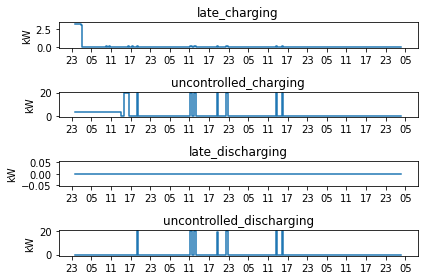

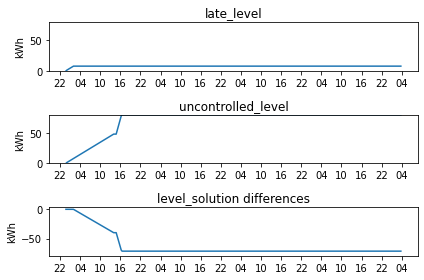

In [62]:
plot_results("charge", car+str(i)) 
plot_results("level", car+str(i))

## Processing EES-profiles: Aggregation

In [63]:
uncontrolled_level_accurate = pd.DataFrame()
uncontrolled_charge_accurate = pd.DataFrame()
early = pd.DataFrame()
late = pd.DataFrame()

for c in consumption_raw.columns.unique():
    
    try: 
        car_list = consumption_raw[c].columns
    
    except AttributeError as a:
        car_list = [car]
            
    for i, car in enumerate(car_list):
        early = pd.concat([
            early, solution_dict[car+str(i)]["m_early"]["level"]
        ], axis=1).sum(1)
        late = pd.concat([
           late, solution_dict[car+str(i)]["m_late"]["level"]
        ], axis=1).sum(1)
        uncontrolled_level_accurate = pd.concat([
            uncontrolled_level_accurate, solution_dict[car+str(i)]["m_early"]["level"]
        ], axis=1).sum(1)
        uncontrolled_charge_accurate = pd.concat([
            uncontrolled_charge_accurate, solution_dict[car+str(i)]["m_early"]["charge"]
        ], axis=1).sum(1)
        
uncontrolled_level_accurate.name = "uncontrolled_level"
uncontrolled_charge_accurate.name = "uncontrolled_charge"        
ees_constraints_aggergated=late-early

<AxesSubplot:>

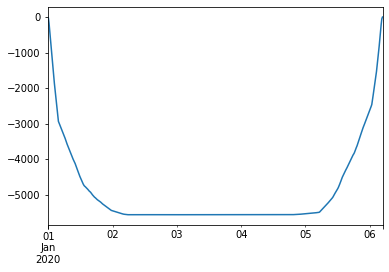

In [64]:
ees_constraints_aggergated = ees_constraints.iloc[:time_steps+1, :profiles].sum(1)
level_index = ees_constraints_aggergated.index
ees_constraints_aggergated.plot()

<AxesSubplot:>

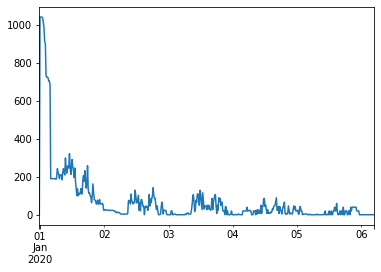

In [65]:
uncontrolled_charge_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), uncontrolled_charge_accurate.loc[level_index[1:]]
              ], axis = 0)
#plt.step(uncontrolled_charge_aggregated.iloc[1:].resample("h").mean().index, uncontrolled_charge_aggregated.iloc[1:].resample("h").sum())
uncontrolled_charge_aggregated.plot()

In [66]:
#aggregation
naive_constraints_aggergated = pd.Series(data=sum(
    car_properties_raw.loc["battery_capacity"][ :profiles]), index=level_index) #all battery capicities
aggregated_max_battery = car_properties_raw.loc["battery_capacity"][ :profiles].sum()

In [67]:
#ees_constraints_02 = pd.read_pickle("short_ees_constraints_min02.pickle")
#pd.concat([ees_constraints_aggergated, ees_constraints_02.sum(1)], axis=1, keys=["SoCmin: 1%","SoCmin: 2%" ]).plot(ylabel="EES level min [kWh]")
#plt.legend(bbox_to_anchor=(1, 1))

<AxesSubplot:>

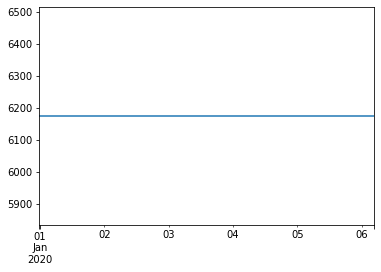

In [68]:
naive_constraints_aggergated.plot()

In [69]:
consumption_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), consumption_raw.loc[level_index[1:]].sum(1)
              ], axis = 0)
#plt.step(consumption_aggregated.iloc[1:].resample("h").mean().index, consumption_aggregated.iloc[1:].resample("h").sum())

In [70]:
power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), power_raw.loc[level_index[1:]].sum(1)
              ], axis = 0)
#plt.step(power_aggregated.iloc[1:].resample("4h").sum().index, power_aggregated.iloc[1:].resample("4h").mean())

In [71]:
neg_power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), neg_power_magnitude_raw.loc[level_index[1:]].sum(1)
              ], axis = 0)
#plt.step(neg_power_aggregated.iloc[1:].index, neg_power_aggregated.iloc[1:]) 

## Aggregated Optimization

In [72]:
#!pip install pickle5
#import pickle5 as pickle
import pickle
with open("prices_2020", "rb") as fh:
    data = pickle.load(fh)

<AxesSubplot:ylabel='el. price [€/kWh]'>

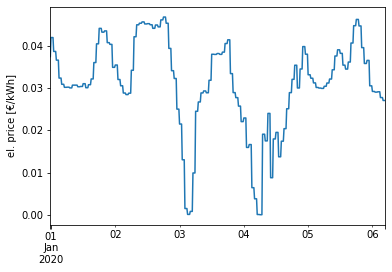

In [73]:
prices = data

prices = prices[prices.index >= "2019-12-31 22:45:00+01:00"]

prices.index =  prices.index.map(
    lambda x: pd.to_datetime(x.replace(tzinfo=None))
)
prices = prices[prices.index.drop_duplicates(keep=False)]
prices = prices.reindex(consumption_aggregated.index, method = "ffill") 
prices = prices / (10**3) # €/MWh --> €/kWh

prices.plot(ylabel="el. price [€/kWh]")

Assumptions: 

- same price for (DIS)CHARGE
- 𝑓𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 = sum(ees_charging_costs)
- controlled costs = uncontrolled_costs - 𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 

In [92]:
agg_solutions = {}
level_0_agg = car_properties_raw.loc["soc_init"].sum() 
level_T_agg = car_properties_raw.loc["soc_end"].sum()

for model_type in ["naive", "ees"]:

    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.Reals)
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_PHYS = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    if model_type == "ees":
        m_agg.ees_min = pyo.Param(m_agg.t, initialize=ees_constraints_aggergated.to_dict()) 
        m_agg.uncontrolled_charge = pyo.Param(m_agg.t, initialize=uncontrolled_charge_aggregated.to_dict()) 
       
    if model_type == "naive":
        def final_level(m_agg, t):
            if t == index[-1]:
                return m_agg.LEVEL[t] == level_T_agg
            else: 
                return pyo.Constraint.Skip
        ##m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
        
        #recursive level
        def recursive_level(m_agg, t):
            if t == level_index[0]:
                return m_agg.LEVEL[t] == (m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t])*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
    else:
        def recursive_level(m_agg, t):
            if t == level_index[0]: 
                return m_agg.LEVEL[t] == level_0_agg + (m_agg.CHARGE[t]- m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t] )*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def level_constraint(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] >= m_agg.ees_min[t] 
        else:
            return m_agg.LEVEL[t] <= aggregated_max_battery
    m_agg.Level_constraint = pyo.Constraint(m_agg.t, rule=level_constraint)
    
    def level_constraint_2(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] <= 0
        else:
            return m_agg.LEVEL[t] >= 0
    m_agg.Level_constraint_2 = pyo.Constraint(m_agg.t, rule=level_constraint_2)
    
    def power_charge_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_charge_max = pyo.Constraint(m_agg.t, rule=power_charge_max)

    if model_type == "ees":
        def power_discharge_consumption_max(m_agg, t):
            return m_agg.DISCHARGE_WAIT[t] <=  m_agg.uncontrolled_charge[t] 
        m_agg.Power_discharge_consumption_max = pyo.Constraint(m_agg.t, rule=power_discharge_consumption_max)
    
    def power_discharge_phys_max(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE_PHYS[t] <= m_agg.neg_power[t] 
        else: 
            return m_agg.DISCHARGE_PHYS[t] ==0
            
    m_agg.Power_discharge_phys_max = pyo.Constraint(m_agg.t, rule=power_discharge_phys_max)

    # objective function
    if model_type == "ees":
        def min_ees_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_WAIT[t]-m_agg.DISCHARGE_PHYS[t]
                ) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_ees_costs = pyo.Objective(rule=min_ees_costs, sense=pyo.minimize)
    else:
        def min_naive_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_PHYS[t]) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_naive_costs = pyo.Objective(rule=min_naive_costs, sense=pyo.minimize)
        
    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        
    
    agg_solutions[model_type] = {}
    agg_solutions[model_type]["costs"] = solved_model['Problem']()['Lower bound']
    agg_solutions[model_type]["CHARGE"] = pd.DataFrame.from_dict(m_agg.CHARGE.extract_values(), orient='index', columns = [model_type])
    if model_type == "ees":
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_WAIT.extract_values(), orient='index', columns = [model_type]) + pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    else:
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["LEVEL"] = pd.DataFrame.from_dict(m_agg.LEVEL.extract_values(), orient='index', columns = [model_type])

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpjkk6giik.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpdprk39ow.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmph_acz4kj.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmph_acz4kj.pyomo.lp'...
2506 rows, 2005 columns, 4509 non-zeros
15041 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpdprk39ow.glpk.glp'...
12531 lines were written
GLPK Simplex Optimizer, v4.65
2506 rows, 2005 columns, 4509 non-zeros
Preprocessing...
500 rows, 1500 columns, 1999 non-zeros
Scaling...
 A: min|aij| =  2.500e-01  max|aij| =  1.000e+00  ratio =  4.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 500
*     0: obj =   0.000000000e+00 inf =   0.000e+00 (59)
*   747: obj =  -6.418894378e+02 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Tim

In [93]:
def plot_aggregated_results(model_type):
    obversvations = 100#len(ees_constraints_aggergated)
    x = level_index[10:obversvations]
    fig, ax = plt.subplots(3)
    ax[0].step(x, 
               pyo.value(agg_solutions[model_type]["CHARGE"].values[10:obversvations]), where="pre")
    ax[0].set_title("{}_charging".format(model_type))
    
    
    ax[1].step(x, 
               pyo.value(agg_solutions[model_type]["DISCHARGE"].values[10:obversvations]), where="pre")
    ax[1].set_title("{}_discharging".format(model_type))
    
    
    ax[2].plot(x, 
               pyo.value(agg_solutions[model_type]["LEVEL"].values[10:obversvations]))
    ax[2].set_title("{}_level".format(model_type))
    ax[2].set_ylabel("kWh")
    
    
    for i in range(0,2):
        ax[i].set_ylabel("kWh/15min")
        ax[i].set_xticks(pd.date_range(x[0], x[-1], freq="D"))
        #plt.set_xticklabels(rotation= 45)
        plt.xticks(rotation= 45)
    fig.autofmt_xdate(rotation=45)


    plt.tight_layout()
    plt.show()

# Analysis

In [94]:
agg_overest_solutions = {}

for model_type in ["m_early_agg", "m_late_agg"]:
    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.NonNegativeReals, bounds=(
        aggregated_max_battery, aggregated_max_battery))
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    #level constraints
    def recursive_level(m_agg, t):
        if t == level_index[0]:
            return m_agg.LEVEL[t] == level_0_agg + m_agg.CHARGE[t] - m_agg.consumption_aggregated[t]
        else:    
            return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                             pd.Timedelta(pd.infer_freq(level_index))] + (
                m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE[t] )
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
    
    #bidirectional charging 
    def neg_power_min(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE[t] <= m_agg.neg_power[t]
        else: 
            return m_agg.DISCHARGE[t] ==0
    m_agg.Neg_power_min_restriction = pyo.Constraint(m_agg.t, rule=neg_power_min)

    def power_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_max_restriction = pyo.Constraint(m_agg.t, rule=power_max)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)

    # objective function late
    def battery_level_sum(m_agg, t): 
        return sum(m_agg.LEVEL[t] for t in m_agg.t) 
    if model_type == "m_late_agg":
        sense = pyo.minimize
    elif model_type == "m_early_agg":
        sense = pyo.maximize     
    m_agg.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        

    #store data in dictionary
    agg_overest_solutions[model_type] = pd.DataFrame.from_dict(
        m_agg.LEVEL.extract_values(), orient='index')[0]

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmp8xbidxe0.glpk.raw --wglp
 C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmptz4yjuft.glpk.glp --cpxlp C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpdcpqn8zr.pyomo.lp
Reading problem data from 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmpdcpqn8zr.pyomo.lp'...
1505 rows, 1504 columns, 3006 non-zeros
9533 lines were read
Writing problem data to 'C:\Users\J7CE7~1.MUE\AppData\Local\Temp\tmptz4yjuft.glpk.glp'...
8381 lines were written
GLPK Simplex Optimizer, v4.65
1505 rows, 1504 columns, 3006 non-zeros
Preprocessing...
PROBLEM HAS NO PRIMAL FEASIBLE SOLUTION
If you need actual output

In [95]:
#overestimation in kWh how much could be shifted from uncontrolled charging?
overestimation_dict = {}

overestimation = 1 + (
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()

print(
    "potential overestimation factor: " + str(
        overestimation) + " : " + str((
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()*100) + " %"
)
                                                  
overestimation_dict[f'profiles: {profiles}, steps: {time_steps}'] =  overestimation 

potential overestimation factor: 0.0 : -100.0 %


In [96]:
#df = pd.DataFrame().from_dict(overestimation_dict, orient="index")
df_profiles = df.iloc[:7]
df_profiles.index = [int(
    i.split(":")[1].split(",")[0]
)
 for i in df_profiles.index]

df_profiles.to_pickle("profiles_overestimation")
df_profiles.plot()
plt.legend(["time_steps: 673"])

df_time_steps = df.iloc[7:]
df_time_steps.index = [int(
    i.split(",")[1].split(":")[1]
)
 for i in df_time_steps.index]

df_time_steps.to_pickle("time_step_overestimation")
df_time_steps.plot()
plt.legend(["profiles: 3311"])

NameError: name 'df' is not defined

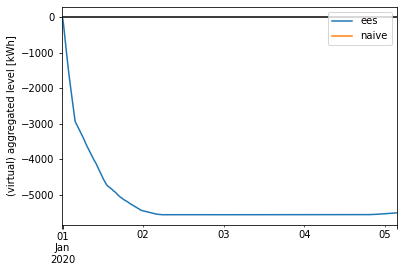

In [98]:
pd.concat([
    ees_constraints_aggergated, (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"])
], keys = ["ees", "naive"],axis=1).iloc[:400].plot(ylabel="(virtual) aggregated level [kWh]")

plt.hlines(0, level_index[0], level_index[-1], "black")

Text(0, 0.5, 'solution space size [kWh]')

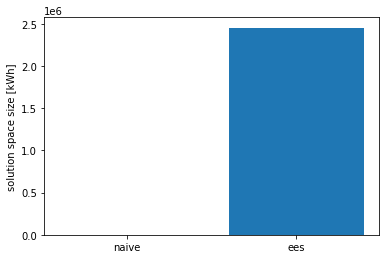

In [99]:
plt.bar(["naive", "ees"], [
    (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"]).sum(),
    -ees_constraints_aggergated.sum()
])
plt.ylabel("solution space size [kWh]")

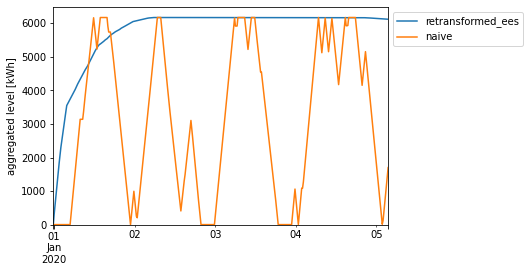

In [100]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
retransformed_ees_level = pd.concat([
    uncontrolled_level_accurate, agg_solutions["ees"]["LEVEL"]
], axis=1).sum(1)
retransformed_ees_level.name = "retransformed_ees"

pd.concat([
    retransformed_ees_level, agg_solutions["naive"]["LEVEL"]
], axis=1).iloc[:400].plot(ylabel="aggregated level [kWh]", ylim=0)


plt.legend(bbox_to_anchor=(1.0, 1.0))

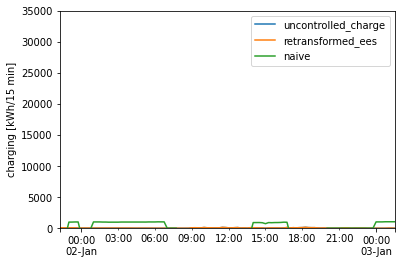

In [101]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
retransformed_ees_charge = pd.concat([
    uncontrolled_charge_accurate.loc[level_index[1:]], agg_solutions["ees"]["CHARGE"], - agg_solutions["ees"]["DISCHARGE"]
], axis=1).sum(1)

naive_dis_charge = pd.concat([
    agg_solutions["naive"]["CHARGE"], - agg_solutions["naive"]["DISCHARGE"]
], axis=1).sum(1)

retransformed_ees_charge.name, naive_dis_charge.name = "retransformed_ees", "naive"

pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge
], axis=1).iloc[90:200].plot(ylabel="charging [kWh/15 min]", ylim=(0, 35000))
plt.legend(bbox_to_anchor=(1.0, 1.0))

In [102]:
pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge
], axis=1).sum(0)

uncontrolled_charge    3.702440e+04
retransformed_ees      3.702440e+04
naive                 -1.091394e-11
dtype: float64

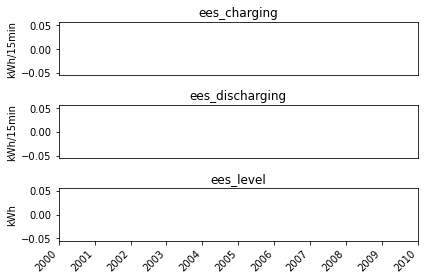

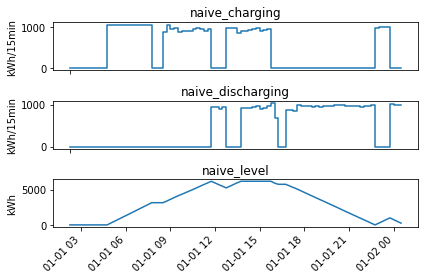

In [103]:
plot_aggregated_results("ees")
plot_aggregated_results("naive")

## Cost

In [104]:
uncontrolled_costs = sum([
    uncontrolled_charge_accurate[i] * prices[i] for i in index
])
controlled_costs_ees = sum([
    retransformed_ees_charge[i] * prices[i] for i in index
])
controlled_costs_naive = sum([
    naive_dis_charge[i] * prices[i] for i in index
])

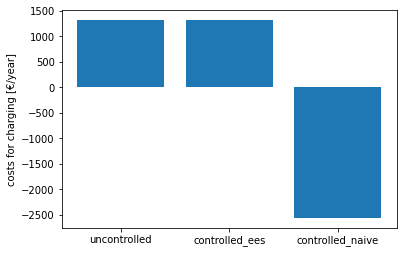

In [105]:
#costs
plt.bar(x = ["uncontrolled", "controlled_ees", "controlled_naive"],  height=[
    uncontrolled_costs, controlled_costs_ees, controlled_costs_naive
])
plt.ylabel("costs for charging [€/year]")
plt.show()

In [106]:
#overestimation in % €
(controlled_costs_ees + controlled_costs_naive) / (-controlled_costs_naive)

-0.48946840471337816